### Imports for Model

In [38]:
import numpy as np
import pandas as pd
from matplotlib import pylab as plt
from IPython import display
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

DATOS_DIR = "data/"
data = pd.read_csv(DATOS_DIR + 'mock_training.csv', sep=',')


### Preprocesing 

In [39]:
# First, process all features
def expand_datetime_column(data: pd.DataFrame) -> pd.DataFrame:
    """Convierte la primera columna de timestamps en columnas separadas (month, day, hour, minute)."""
    data = data.copy()

    # Convertir la primera columna a datetime con soporte UTC
    col0 = data.columns[0]
    data[col0] = pd.to_datetime(data[col0], utc=True, errors="coerce")

    # Comprobar si hubo fallos
    if data[col0].isna().any():
        print("⚠️ Algunas fechas no se pudieron convertir correctamente.")

    # Crear columnas separadas
    data["month"] = data[col0].dt.month
    data["day"] = data[col0].dt.day
    data["hour"] = data[col0].dt.hour
    data["minute"] = data[col0].dt.minute

    # Eliminar la columna original
    data = data.drop(columns=[col0])

    return data



# Apply datetime expansion
data = expand_datetime_column(data)

# El wind_direction conviene representarlo como dos componentes vectoriales (ya que es un ángulo cíclico):
data["wind_x"] = data["wind_speed"] * np.cos(np.deg2rad(data["wind_direction"]))
data["wind_y"] = data["wind_speed"] * np.sin(np.deg2rad(data["wind_direction"]))

# Drop original wind columns
data = data.drop(columns=["wind_direction", "wind_speed"])

# Convert boolean columns to int
data["working_day"] = data["working_day"].astype(int)
data["holiday"] = data["holiday"].astype(int)

# Finally, separate features and labels
X = data.drop(columns=["consumption"])
T = data["consumption"]


In [42]:
# Normalización Z-score
x_scaler = StandardScaler()
X_scaled = x_scaler.fit_transform(X)

# Escalar también la variable objetivo
y_scaler = StandardScaler()
T_scaled = y_scaler.fit_transform(T.values.reshape(-1, 1))


# División train-test
X_train, X_test, T_train, T_test = train_test_split(
    X_scaled, T_scaled, test_size=0.2, random_state=42
)


### Model

In [43]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras import optimizers

model = Sequential([
    Dense(64, activation='relu', input_dim=X_train.shape[1]),
    Dense(32, activation='relu'),
    Dense(16, activation='relu'),
    Dense(1, activation='linear')  # salida lineal para regresión
])

optimizer = optimizers.Adam(learning_rate=0.001)  # mucho más eficiente que SGD

model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
model.summary()


c:\Users\manus\OneDrive\Documentos\Facultad\2025\Segundo Semestre\SdTR\STR\env\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_16 (Dense)                │ (None, 64)             │         1,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,777 (14.75 KB)

 Trainable params: 3,777 (14.75 KB)

 Non-trainable params: 0 (0.00 B)

### Training

In [44]:
es = EarlyStopping(monitor='val_loss', patience=30, min_delta=0.0001)


history = model.fit(X_train, T_train,batch_size=64,
                    epochs=800,
                    verbose=0,  # cambiar a 1 si querés ver la salida
                    validation_data=(X_test, T_test),callbacks=[es])

### Evaluation

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
Loss de test: 0.0471, Métrica: 0.1703
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 774us/step


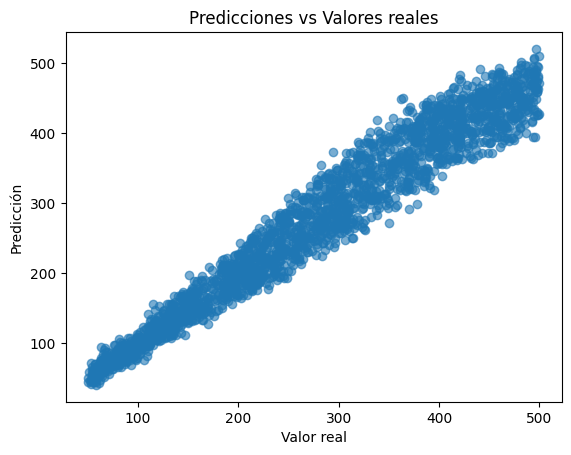

In [45]:
pred_scaled = model.predict(X_test)
pred = y_scaler.inverse_transform(pred_scaled)
T_real = y_scaler.inverse_transform(T_test)


# Evaluación del modelo
loss, metric = model.evaluate(X_test, T_test, verbose=0)
print(f"Loss de test: {loss:.4f}, Métrica: {metric:.4f}")

# Predicciones
y_pred = model.predict(X_test)

plt.scatter(T_real, pred, alpha=0.6)
plt.xlabel("Valor real")
plt.ylabel("Predicción")
plt.title("Predicciones vs Valores reales")
plt.show()




Versión de TensorFlow: 2.20.0
Dispositivos físicos detectados por TensorFlow:
 • PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')

❌ TensorFlow no detecta GPU. Está usando CPU.
